# Investigation of Bayesian EDGES calibration

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from edges_cal.cal_coefficients import CalibrationObservation, LoadSpectrum
import os
from scipy.signal import medfilt
import pickle
import logging
from edges_io.logging import logger
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from typing import List, Dict, Optional
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm
import attr
from yabf import Component, Likelihood, Parameter, Param, run_map, LikelihoodContainer
from yabf.chi2 import MultiComponentChi2
from cached_property import cached_property
from yabf import samplers
from yabf.core.samplers import curve_fit as cfit
logger.setLevel(logging.INFO)
from edges_estimate import LinLog, AbsorptionProfile
from scipy import stats
from edges_cal import modelling as mdl
%load_ext autoreload
%autoreload 2

This notebook is a development notebook for the paper [here](https://www.overleaf.com/9477723471yvqbvyshqjph). 
It is *not* the place to produce publication-ready plots, but is rather a melting pot of ideas.

Note that a previous version of this notebook exists in `../cal-output` as `devel-edges-cal-mcmc.ipynb`.

Mostly, these ideas will be a applied to a single representative calibration observation.

## Setup

In [12]:
import edges_io

In [13]:
edges_io.__version__

'0.0.post0.dev1+ga3f7b1e'

In [2]:
# note to self: don't use November 2019 calibration since it's a bit weird.
path =  '/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2019_10_01_040_to_200MHz/'

### Define Calibration Observations

In [3]:
calobs = CalibrationObservation(
    path=path,
    load_kwargs={'cache_dir':'/data4/smurray/edges_cal_cache', 'ignore_times_percent':5,},
    f_low=40, f_high=190, run_num=None, cterms=10, wterms=12, 
    s11_kwargs={'resistance':50.1501},resistance_f=49.999,
    compile_from_def=False,
)


ERROR  | outputs is an extraneous file/folder


FileStructureError: 

## View Basic Calibration Quantities

Let's try to check a few things to see if the solutions make sense. This uses the traditional calibration. It's just to confirm that we're using data that makes some sense.

INFO   | Reducing ambient spectra...
INFO   | Saving reduced spectra to cache at /data4/smurray/edges_cal_cache/ambient_ae383a262d2fc59bbfd9af9a28dc6f49.h5
INFO   | Reducing hot_load spectra...
INFO   | Saving reduced spectra to cache at /data4/smurray/edges_cal_cache/hot_load_b81c40e38c52666ca291316d32658754.h5
INFO   | Reducing open spectra...
INFO   | Saving reduced spectra to cache at /data4/smurray/edges_cal_cache/open_702efd813127380e8c7cbeb8c5d5f658.h5
INFO   | Reducing short spectra...
INFO   | Saving reduced spectra to cache at /data4/smurray/edges_cal_cache/short_75173026ff8413b20a93c331a6d7d66c.h5
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:341: LinAlgWarning: Ill-conditioned matrix (rcond=1.26264e-17): result may not be accurate.
  return sp.linalg.solve(r, np.dot(q.T, Wydata)).flatten()
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:341: LinAlgWarning: Ill-conditioned matrix (rcond=6.25187e-18): result may not 

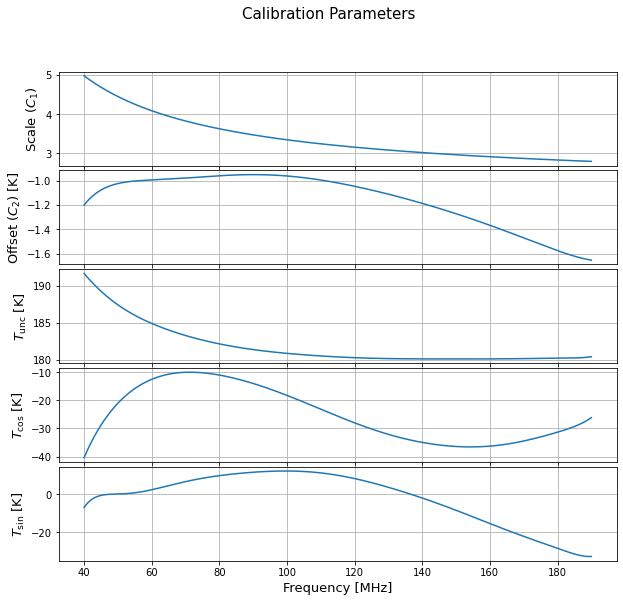

In [20]:
calobs.plot_coefficients();

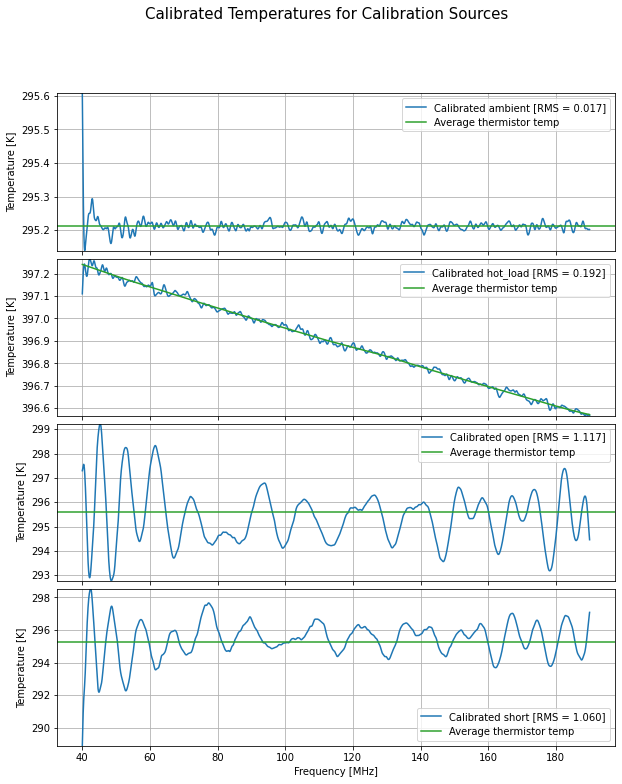

In [14]:
calobs.plot_calibrated_temps(bins=50);

This looks "okay". Let's try going the other way, and _decalibrate_ the input temperature:

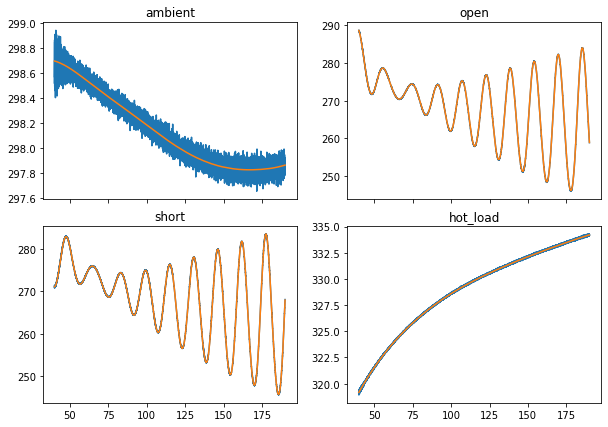

In [18]:
fig, ax = plt.subplots(2,2, sharex=True, gridspec_kw={"hspace": 0.15}, figsize=(10,7))

for i, kind in enumerate(['ambient', 'open', 'short', 'hot_load']):
    src = getattr(calobs, kind)
    ax.flatten()[i].plot(calobs.freq.freq, src.averaged_spectrum)
    ax.flatten()[i].plot(calobs.freq.freq, calobs.decalibrate(src.temp_ave, src))
    ax.flatten()[i].set_title(kind)

Wonderful!

## Noise Investigation

In this section, we'll look at the noise properties of the calibrators, and see if we can determine the correct noise model (as a function of calibration parameters).

### Gaussianity

The first thing to do is to ensure that each channel is roughly Gaussian. This is actually quite difficult, because what we really need to ensure is that the _mean_ (over time samples) of $T^*_{\rm load}$ is Gaussian. However, taking the mean over the time samples means we are left with a single sample.

We can show the distribution of a single sample of $T^*_{\rm load}$:

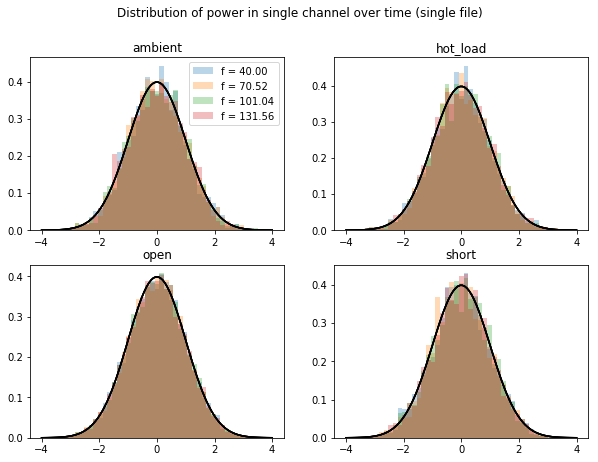

In [49]:
fig, ax = plt.subplots(2,2, figsize=(10, 7))

x = np.linspace(-4, 4, 100)
gauss = np.exp(-x**2/2)/(np.sqrt(2*np.pi))

for i, load in enumerate(calobs._sources):
    data = getattr(calobs, load).spectrum.get_spectra()['Qratio']
    
    for index in [0, 5000, 10000, 15000]:
        d = data[index]
        
        # Remove outliers
        md = np.median(d)
        mad = np.median(np.abs(d - md))
        d = d[np.logical_and(d > md - 5*mad, d < md + 5*mad)]
        
        ax.flatten()[i].hist(
            (d - np.mean(d))/np.std(d), 
            label=f"f = {calobs.freq.freq[index]:.2f}",
            alpha=0.3,
            density=True,
            bins = np.linspace(-4, 4, 50)
        )
        ax.flatten()[i].set_title(load)
        ax.flatten()[i].plot(x, gauss, color='k')
ax[0,0].legend();
fig.suptitle("Distribution of power in single channel over time (single file)");

The mean of a set of Gaussian's is going to be Gaussian, so we are home-and-hosed.

### Covariance

What about covariance between frequency bins? 

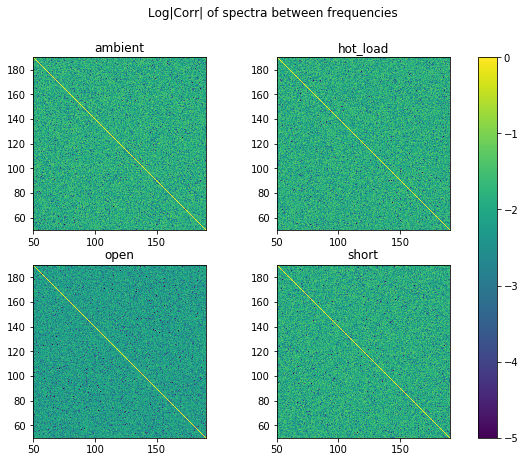

In [213]:
fig, ax = plt.subplots(2,2, figsize=(10, 7))

for i, load in enumerate(calobs._sources):
    data = getattr(calobs, load)._read_spectrum()
    
    # Get rid of NaNs
    var = np.var(data, axis=0)
    data = data[:, ~np.isnan(var)]
    
    # To make it a bit more manageable, restrict frequency bins up to 5000
    data = data[:5000]
    
    cov = np.cov(data)
    corr = cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov)))
    
    im = ax.flatten()[i].imshow(np.log10(np.abs(corr)), vmin=-5, vmax=0, extent=(calobs.freq.min, calobs.freq.max)*2)
    ax.flatten()[i].set_title(load)
    
plt.colorbar(im, ax=ax)
    
fig.suptitle("Log|Corr| of spectra between frequencies");

I think this is good enough to say that there is very little correlation between frequency bins.

### Calibrate without noise-waves or a model of variance

If we ignore the fact that we have a _model_ of $\sigma^2_Q$, we could use the empirical variance that we measure (assumed without uncertainty) and then just use our model for $Q$:

\begin{align}
    Q_t \approx \frac{T_A - T_L}{T_{NS}} \left(1 - \frac{\alpha(T_L^2 + T_{LNA}^2)}{T_{NS} (T_A - T_L)} + \frac{\alpha\left[2T_L^2 + T_{NS}^2 + 2T_{LNA}^2\right]}{T_{NS}^2}\right).
\end{align}

The problem with this is that no matter how many measurements we have of $Q_t$ and $T_A$, the basis set as measured is entirely degenerate (i.e. you can pick any old $T_{NS}$ and entirely compensate by adjusting $T_{LNA}$). Thus, we need to recast the fit as

\begin{equation}
    Q_t \approx \frac{T_A - T_L}{T'_{NS}},
\end{equation}
where $T'_{NS}$ is modified by the term in brackets. Alternatively, we may consider _fixing_ $T_{LNA}$ to some fiducial value, and then solving for $T_{NS}$ as normal.

Firstly, throughout all of this, we will use the following:

In [ ]:
Q_measured={k: source.averaged_Q for k, source in calobs._loads.items()}
varQ_measured={k: source.spectrum.variance_Q / source.spectrum.n_integrations for k, source in calobs._loads.items()}
varQt_measured={k: source.spectrum.variance_Q  for k, source in calobs._loads.items()}
temp_ant={k: source.temp_ave for k, source in calobs._loads.items()}
alpha=1/(13.0 * calobs.freq.df*1e6)

We will use `yabf` to build our model, as it provides a lot of flexibility.

In [ ]:
@attr.s(frozen=True)
class Poly(Component):
    def __new__(cls, poly_order=5, *args, **kwargs):
        # First create the parameters.
        p = []
        for i in range(poly_order):
            p.append(Parameter(f"p{i}", 0, latex=r"p_{}".format(i)))
        cls.base_parameters = tuple(p)

        obj = super(Poly, cls).__new__(cls)

        return obj

    x = attr.ib(kw_only=True)
    poly_order = attr.ib(5, kw_only=True, converter=int)

    @cached_property
    def provides(self):
        return [f"{self.name}"]

    def calculate(self, ctx, **params):
        p = [params[f'p{i}'] for i in range(self.poly_order)]
        return sum([pp * self.x ** i for i, pp in enumerate(p)])

In [ ]:
@attr.s(frozen=True)
class Chi2(Likelihood):
    base_parameters = [
        Parameter("sigma", 1, min=0, latex=r"\sigma")
    ]

    x = attr.ib(kw_only=True, default=None)

    def _reduce(self, ctx, **dct):
        model = np.array([v for k, v in ctx.items() if k.endswith("model")])
        return np.sum(model, axis=0)

    def _mock(self, model, **params):
        return model + np.random.normal(loc=0, scale=params['sigma'], size=len(model))

    def lnl(self, model, **params):
        sigma = params['sigma']
        nm = norm(loc=model, scale=sigma)

        lnl = np.nansum(nm.logpdf(self.data))
        # lnl = np.nansum(-(self.data - model)**2 / (2 * sigma**2))
    
        if np.isnan(lnl):
            lnl = -np.inf

        return lnl

In [ ]:
t_ns = Poly(
    name = 't_ns',
    poly_order=1,
    x=calobs.freq.freq,
    params = (
        Param('t_ns', fiducial=400, min=300, max=2000, ref=norm(400, 1), determines=('p0',)),
    )
)

t_l = Poly(
    name = 't_l',
    poly_order=1,
    x=calobs.freq.freq,
    params = (
        Param('t_l', fiducial=300, min=200, max=500, ref=norm(300, 1), determines=('p0',)),
    )
)

t_lna = Poly(
    name = 't_lna',
    poly_order=1,
    x = calobs.freq.freq,
    fiducial={'p0': 50}
)

In [ ]:
@attr.s(frozen=True)
class ModelQ(Component):

    alpha = attr.ib(kw_only=True, default=0)
    get_var = attr.ib(kw_only=True, default=False)
    t_ant = attr.ib(kw_only=True)
    n_integrations = attr.ib(kw_only=True, default=1)
    
    @cached_property
    def provides(self):
        if not self.get_var:
            return ['Q_model']
        else:
            return ['Q_model', 'Q_var']
    
    @staticmethod
    def model_Q_no_noise_wave(t_ant: [float, np.ndarray], t_ns: [float, np.ndarray], 
                              t_l: [float, np.ndarray], t_lna: [float, np.ndarray] = 50, 
                              alpha: float = 0.0):
        front = (t_ant - t_l)/t_ns
        return front * (1 - alpha * (t_l**2 + t_lna**2)/ (t_ns*(t_ant - t_l)) + alpha * (2*t_l**2 + t_ns**2 + 2*t_lna**2)/t_ns**2)

    @staticmethod    
    def var_Q_no_noise_wave(t_ant: [float, np.ndarray], t_ns: [float, np.ndarray], 
                            t_l: [float, np.ndarray], t_lna: [float, np.ndarray] = 50, alpha: float = 0.0, n_integrations: int=1):
        front = alpha * (t_ant - t_l)**2 / t_ns**2 / n_integrations
        return front * ((t_ant**2 + 2*t_lna**2 + t_l**2)/(t_ant - t_l)**2 - 2*(t_l**2 + t_lna**2)/(t_ns*(t_ant - t_l)) + (2*t_l**2 + 2*t_lna**2 + t_ns**2)/t_ns**2)


    def calculate(self, ctx, **params):
        t_lna = ctx['t_lna']
        t_l = ctx['t_l']
        t_ns = ctx['t_ns']
        model = self.model_Q_no_noise_wave(self.t_ant, t_ns, t_l, t_lna, self.alpha)

        if self.get_var:
            return model, self.var_Q_no_noise_wave(self.t_ant, t_ns, t_l, t_lna, self.alpha, self.n_integrations)
        return (model,)

In [ ]:
lks = LikelihoodContainer(
    [
        Chi2(
            name=source,
            data=Q_measured[source],
            fiducial={'sigma': np.sqrt(varQ_measured[source])},
            components=(ModelQ(alpha=alpha, t_ant=temp_ant[source], components=(t_ns, t_l, t_lna)),)
        ) for source in Q_measured
    ]
)

In [53]:
fit = run_map(lks)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1783: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1784: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


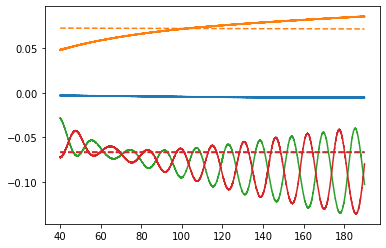

In [54]:
model = lks.reduce_model(params=fit.x)
for i, kind in enumerate(['ambient', 'hot_load', 'open', 'short']):
    plt.plot(calobs.freq.freq, lks[kind].data, color=f"C{i}", ls='-')
    plt.plot(calobs.freq.freq, model[kind], color=f"C{i}", ls='--')

Note that the frequency structure in the measured $Q$ here is _not_ assumed to arise from the internal temperatures themselves, but rather from internal reflections and the gain, which we have completely omitted in this treatment. Thus, the fits here are pretty good -- the get approximately the mean of each $Q$. It does not seem like any of the $Q$ are inconsistent, which means our model is reasonable, up to the frequency dependence.

What we would like to do now is to estimate the variance, given the best fit, and compare to the measured variance:

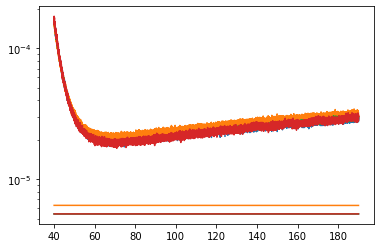

In [65]:
for i, kind in enumerate(['ambient', 'hot_load', 'open', 'short']):
    var = lks[kind]['ModelQ'].var_Q_no_noise_wave(t_ant=temp_ant[kind], t_ns=fit.x[0], 
                            t_l=fit.x[1], t_lna= 50, alpha=alpha)
    var *= np.ones_like(calobs.freq.freq)
    plt.plot(calobs.freq.freq, var, color=f"C{i}", ls='-')
    plt.plot(calobs.freq.freq, varQt_measured[kind] , color=f"C{i}", ls='--')
    
plt.yscale('log')

This is *not* so good -- the amplitude is off by a factor of ~4 in the variance. What could the discrepancy be? Almost certainly, the problem is something to do with a mis-calculated $\alpha$. We haven't taken into account the window function here, which should decrease effective number of samples by ~2. There also might be another factor of two in there?

Let's try again with a larger $\alpha$:

In [70]:
lks = LikelihoodContainer(
    [
        Chi2(
            name=source,
            data=Q_measured[source],
            fiducial={'sigma': np.sqrt(varQ_measured[source])},
            components=(ModelQ(alpha=alpha*4, t_ant=temp_ant[source], components=(t_ns, t_l, t_lna)),)
        ) for source in Q_measured
    ]
)

In [71]:
fit = run_map(lks)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1783: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1784: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


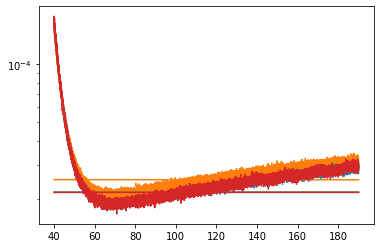

In [73]:
for i, kind in enumerate(['ambient', 'hot_load', 'open', 'short']):
    var = lks[kind]['ModelQ'].var_Q_no_noise_wave(t_ant=temp_ant[kind], t_ns=fit.x[0], 
                            t_l=fit.x[1], t_lna= 50, alpha=alpha*4)
    var *= np.ones_like(calobs.freq.freq)
    plt.plot(calobs.freq.freq, var, color=f"C{i}", ls='-')
    plt.plot(calobs.freq.freq, varQt_measured[kind] , color=f"C{i}", ls='--')
    
plt.yscale('log')

There are clearly some out-of-band effects at the lower end, as well as frequency-dependent effec

In [ ]:
out_of_band_model_data = np.genfromtxt("out-of-band-noise-model.txt")
out_of_band_model_data[:,0]/=1e6
out_of_band_model_data[:,1] = 10**(out_of_band_model_data[:,1]/10)
out_of_band_model = spline(out_of_band_model_data[:,0], out_of_band_model_data[:,1])

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in sqrt


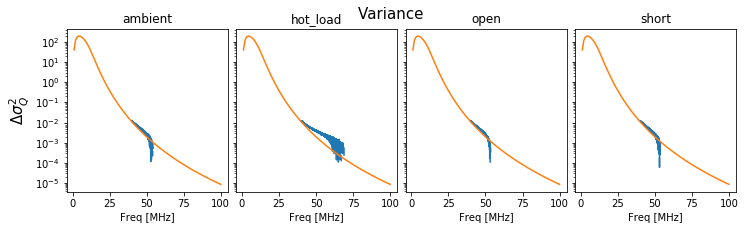

In [57]:
fig, ax = plt.subplots(1,4, figsize=(12, 3), sharex=True, sharey='row', 
                       gridspec_kw={"hspace":0.15, 'wspace':0.05}, subplot_kw={"yscale":'log'})


for i, load in enumerate(calobs._sources):
    
    ax[i].set_title(load)

    mysig = model_variance(calobs, load, Tr=Tr, int_time=int_time, b=b)
    
    if load == 'hot_load':
        multiplier = 11.7 #5.15
    else:
        multiplier = 22.5

    ax[i].plot(
        calobs.freq.freq,
        np.sqrt(getattr(calobs, load).spectrum.variance_Q - multiplier*mysig),
    )
    
    ax[i].plot(
        out_of_band_model_data[:,0],
        out_of_band_model_data[:,1] / 1e4
    )

    if i==0:
        ax[i].set_ylabel("$\Delta \sigma^2_Q$", fontsize=15)        
        
    #ax[i].set_ylim(1e-5,2e-1)
    
for i in range(4):
    ax[i].set_xlabel("Freq [MHz]")

    
fig.suptitle("Variance", fontsize=15);

We also show the *mean* spectra for $Q$ and the switch positions:

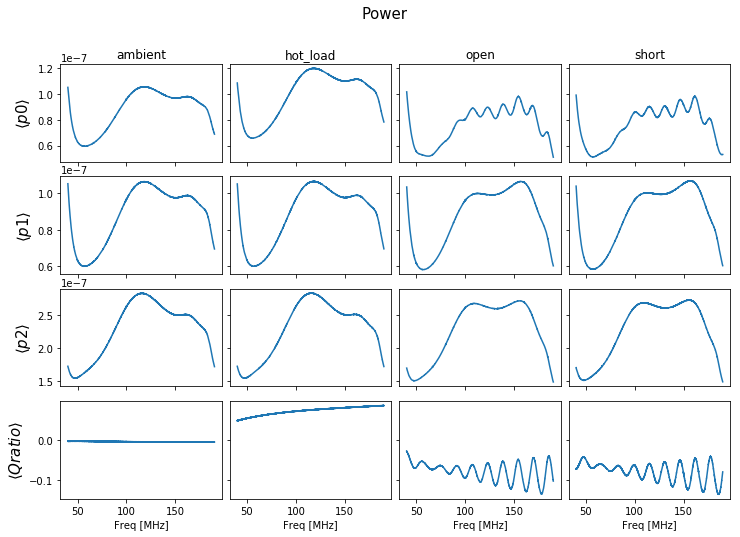

In [58]:
fig, ax = plt.subplots(4,4, figsize=(12, 8), sharex=True, sharey='row', 
                       gridspec_kw={"hspace":0.15, 'wspace':0.05})

for i, load in enumerate(calobs._sources):
    for j, (k, mn) in enumerate(getattr(calobs, load).spectrum._ave_and_var_spec[0].items()):
        ax[j,i].plot(calobs.freq.freq, mn)

        if j==0:
            ax[j,i].set_title(load)
        
        if i==0:
            if k=='ant_temp':
                ax[j,i].set_ylabel(r"$\langle Q \rangle$", fontsize=15)
            else:
                ax[j,i].set_ylabel(r"$\langle %s \rangle$"%k,fontsize=15)
                
        
for i in range(4):
    ax[3,i].set_xlabel("Freq [MHz]")

    
fig.suptitle("Power", fontsize=15);

Note that at least $p_0$ and $p_1$ show hints of an upturn at the lower frequencies. This is to be expected if some out-of-band power is creeping in. This should be heavily alleviated in the ratio $Q$.

Some immediate questions:

  1. **The low-frequency mis-match**. This is due to injected out-of-band noise which has assumed to be cut out below 50 MHz, but clearly has not been fully. We should model this with an equation. We should also determine if we expect a _bias_ from this component.
  2. **The mismatch in amplitude**. This may arise from an incorrect specification of $T_R$. It would be in our interest to _measure_ $T_R$ so that we can try to get these amplitudes aligned.
  3. **`hot_load`**: The 'wrongness' of the amplitude here is far greater. The hot load is weird, and should probably be treated independently anyway.

### Defining the Calibration Formalism more tightly

#### Setting Up The Formalism

Given some of the ambiguities/questions of the previous section, I would like to go through the derivation of the calibration formalism here, in an effort to reconcile some things.

We (again) start with the definition of the normalised power:

\begin{equation}
  \mathbf{Q}_p = \frac{\mathbf{P}^i_A - \mathbf{P}^j_L}{\mathbf{P}^k_{NS} - \mathbf{P}^j_L},
\end{equation}

However, instead of assuming that all noise passes through the system in one direction, we want to try to correct for internal reflections from the LNA _back_ to the source, then back through the LNA again. We also want to account for _any other sources of noise behind the LNA that might exist_. One such source is a large out-of-band noise source which is filtered such that it should be cut-off below ~40MHz.

Following Monsalve (2017) (hereafter M17), we would write (ignoring for the moment any post-LNA noise sources)

\begin{align}
    P_A &= g\left[k_0 \mathbf{T}_A + k_1\mathbf{T}_{unc} + k_2 \mathbf{T}_{cos} + k_3\mathbf{T}_{sin} + \mathbf{T}_R \right], \\
    P_L &= g^*\left[h_0 \mathbf{T}_L + \mathbf{T}_R \right], \\
    P_{NS} &= g^*\left[h_0 (\mathbf{T}_L + \mathbf{T}_{NS}) + \mathbf{T}_R\right].
\end{align}

Here $g$ is the gain induced by the LNA in its interface with the antenna, while $g^*$ is the gain through the load and noise-source pathway. Since these are expected to be close, we write $g^* = g(1 + \delta_g)$, with $\delta_g \ll 1$. 
$\mathbf{T}_R$ is noise offset produced by the LNA itself. 

$\mathbf{T}_{unc}, \mathbf{T}_{cos}$ and $\mathbf{T}_{sin}$ are the _noise-wave_ parameters, which quantify standing-wave contributions of the noise reflected from the LNA back to the antenna. In this context, it is my understanding that "uncorrelated" is in the sense of "neither in phase nor out of phase" and so the "cos" and "sin" components are not _statistically_ correlated, but rather in- or out-of-phase with the noise from the antenna itself passing through the LNA. 

There are a few important things that I need to understand about the noise-wave parameters, which I'm not quite sure I do yet: 

1. Do they come from the same thermal source? i.e. can they be considered independent sources of noise, or is it just parts of the same thermal source? This has ramifications, i.e. the variance of the temperature in the first case is the sum of the variances, whereas in the second case, it is the variance of the sum. In general, they may be partially correlated with each other.
2. Do the noise-wave parameters define a part of the temperature actually just emitted by $T_R$? I.e. is the noise actually emitted by the LNA just split into two groups -- one that goes forward and one that is reflected? Do they lower the effective $T_R$?
3. Are the noise-wave temperatures _statistically correlated_ with either $T_R$ or $T_A$? This feels tricky. The actual value of $\mathbf{T}_A$ at any given moment produces some part of what gets reflected, so the reflection is statistically correlated. However, that reflection arrives back to be added into the noise at a slightly later time. Now, a whole bunch of times are averaged together to create a single snapshot spectrum. If the rebound time is less than the integration time for a single snapshot, then we expect them to be correlated, otherwise we expect different snapshots to be correlated. We know the latter is not true (to a significant degree), so probably the former is. 

To proceed, I'm going to assume that each of the noise-wave temperatures are independent from each other, and also from the antenna and receiver temperatures. I think this makes sense, as the exact amount that's reflected is probably a random number, almost making it independent of the amount going through. Then of course the reflections back from the antenna interface is another random number... and this happens multiple times, probably rendering each of the numbers completely independent. For the second question, I think probably they do reduce the effective $T_R$ and $T_A$, but perhaps we can get away with just treating $T_R$ as a fittable "effective" parameter, and ignore the effect on $T_A$. In any case, their numbers are probably small. 


For completeness, we have
\begin{align}
    k_0 &= (1 - |\Gamma_{ant}|^2)|F|^2, \\
    k_1 &= |\Gamma_{ant}|^2 |F|^2, \\
    k_2 &= |\Gamma_{ant}| |F| \cos \alpha, \\
    k_3 &= |\Gamma_{ant}| |F| \sin \alpha, \\
    h_0 &= (1 - |\Gamma_{ant}|^2),\\
    F &= \frac{\sqrt{1 - |\Gamma_{rec}|^2}}{1 - \Gamma_{ant}\Gamma_{rec}}, \\
    \alpha &= {\rm arg}(\Gamma_{ant}F).
\end{align}

On top of the general form from M17 above, we also want to add post-LNA noise. We re-write:

\begin{align}
    \mathbf{P}_A &= \sum_{m} g_p^m \mathbf{T}^m_p + g\left[k_0 \mathbf{T}_A + k_1\mathbf{T}_{unc} + k_2 \mathbf{T}_{cos} + k_3\mathbf{T}_{sin} + \mathbf{T}_R \right], \\
    \mathbf{P}_L &= \sum_{m} g^p_m \mathbf{T}^m_p + g(1 + \delta_g)\left[h_0 \mathbf{T}_L + \mathbf{T}_R\right], \\
    \mathbf{P}_{NS} &= \sum_{m} g^p_m \mathbf{T}^m_p + g(1 + \delta_g)\left[h_0 (\mathbf{T}_L + \mathbf{T}_{NS}) + \mathbf{T}_R\right].
\end{align}

where $\mathbf{T}^m_p$ is the post-LNA temperature added to the system at point $m$, which have the same expectation for each source, and $g_p^m$ is the associated gain for that contribution (assumed to be throughout the rest of the system). Note that these equations only make sense if the system is linear (i.e. temperatures are scaled linearly at any point). In this case, the full equations can be specified using simple linear algebra.

#### Expectation of Q

The first question to ask is what is $Q_P = \langle \mathbf{Q}_P\rangle$.

Using the Taylor expansion of a ratio, we have the relation
\begin{align}
    \langle \mathbf{X}/\mathbf{Y} \rangle \approx \frac{\mu_X}{\mu_Y} - \frac{{\rm Cov}(X, Y)}{\mu_Y^2} + \frac{{\rm Var}(Y)\mu_X}{\mu_Y^3}. 
\end{align}

We have $\mathbf{X} = \mathbf{P}_A^i - \mathbf{P}_L^j$ and $\mathbf{Y} = \mathbf{P}_{NS}^k - \mathbf{P}_L^j$.

So we have
\begin{align}
    \mu_X &= g [k_0 T_A + k_1 T_{unc} + k_2 T_{cos} + k_3 T_{sin} - T_R\delta_g - (1 + \delta_g)h_0T_L)] \\
    \mu_Y &= g(1 + \delta_g) h_0 T_{NS},\\
    {\rm Cov}(X,Y) &= {\rm Var}(P_L), \\
    {\rm Var}(Y) &= {\rm Var}(P_{NS}) + {\rm Var}(P_L).
\end{align}

Since we expect $\mu_Y \gg \mu_X$, we expect the second and third terms to be sub-dominant (but potentially important for precise calibration). I believe these terms are what Alan has been referring to as "noise bias". For now, to try to compare to the solution of M17, let us drop the second and third term til later.

Then we have
\begin{align}
 \langle \mathbf{Q}_P \rangle \approx \frac{k_0 T_A + k_1 T_{unc} + k_2 T_{cos} + k_3 T_{sin} - T_R\delta_g  - (1 + \delta_g)h_0T_L)}{(1 + \delta_g) h_0 T_{NS}} + \mathcal{O}(T_{NS}^{-2}).
\end{align}

Setting $k_x/h_0 \equiv K_x$, we have 
\begin{align}
 (1+\delta_g) T_{NS} \langle \mathbf{Q}_P\rangle  + \delta_g T_R + (1+\delta_g)T_L \approx K_0 T_A + K_1 T_{unc} + K_2 T_{cos} + K_3 T_{sin} + \mathcal{O}(T_{NS}^{-1})
\end{align}

In M17, neither $T_{NS}$ nor $T_L$ really mean what they seem -- they are static "guesses" which get modified by an amount in order to approximate their true values, along with some extra bits and pieces that might not have been explicitly modelled. In the end, the important thing is that the equation is linear, which is what we also have here. 
Our equation is the same as M17 if we set

\begin{align}
    C_1 T_{\rm NS}^{\rm M17} = (1 + \delta_g)T_{\rm NS}, \\
    T_L^{\rm M17} - C_2 = T_R \delta_g + (1 + \delta_g)T_L.
\end{align}

Notably, if the "guess" of $T_{NS}$ was correct, then $C_1$ and $C_2$ correspond purely to the difference in gain between switches.

Given that the form $\delta_g$ is unknown, $T_{NS}$ is unknown, $T_R$ is unknown and $T_L$ is unknown -- it is just as effective to model them with just two parameters, which we will call $T^{\rm eff}_{\rm NS}$ and $T^{\mathrm eff}_L$. This leads to 

\begin{align}
    C_1 T_{\rm NS}^{\rm M17} = T^{\rm eff}_{\rm NS}, \\
    T_L^{\rm M17} - C_2 = T^{\rm eff}_L,
\end{align}

and 

\begin{align}
 T^{\rm eff}_{NS} \langle \mathbf{Q}_P\rangle  + T^{\rm eff}_L \approx K_0 T_A + K_1 T_{unc} + K_2 T_{cos} + K_3 T_{sin} + \mathcal{O}(T_{NS}^{-1}).
\end{align}

This equation holds regardless of my queries concerning the noise-wave parameters above -- those concerns only come into the second and third terms. 

#### Variance of Q

Using our taylor-expanded variance:
\begin{equation}
    {\rm Var}(X/Y) = \frac{\mu_X^2}{\mu_Y^2}\left(\frac{{\rm Var}(X)}{\mu_X^2} - 2\frac{{\rm Cov}(X,Y)}{\mu_X\mu_Y} + \frac{{\rm Var}(Y)}{\mu_Y^2} \right),
\end{equation}

we additionally have

\begin{align}
    {\rm Var}(X) = {\rm Var}(P_A) + {\rm Var}(P_L).
\end{align}



Notice that while to first order, the expectation of $\mathbf{Q}$ had no dependence on the post-LNA noise sources, the variance most definitely does: each of the variance terms involves such a term (but not the covariance). Note also that the post-LNA term _only_ shows up as a variance, its expectation is always cancelled. Furthermore, its variance is a quadrature-sum of its various terms, and henceforth we'll just label the whole thing $\sigma^2_p$. 

As an initial stab, we might expect that the dominant source of $\sigma^2_p$ is just the out-of-band noise down around 40 MHz. To make estimating this more feasible, we attach a functional form to it (the exact form will probably have to be tinkered with experimentally):

\begin{equation}
    \sigma_p = T^{eff}_p f_p(\nu).
\end{equation}

#### No Noise-Waves But Including T_p

For a moment, let us retract the complexities of the noise-wave formalism again, but include the post-LNA noise. Note that in this case, one cannot simply cancel the factors of $g$ as we had done previously. Nevertheless, $\mu_X$ and $\sigma_Y$ are the same, but multiplied by this factor of $g$ (i.e. post-LNA noise is omitted). We also have 

\begin{align}
    \sigma^2_X /\alpha &= 2 \sigma^2_p + g^2(T_A^2 + 2T_R^2 + T_L^2), \\
    \sigma^2_Y/\alpha &= 2 \sigma^2_p + g^2(T_{NS}^2 + 2T_L^2 + 2T_R^2), \\
    {\rm Cov}(X,Y)/\alpha &= \sigma^2_p + g^2(T_L^2 + T_R^2).
\end{align}

Using these values in the equation for the total variance gives us 
\begin{align}
    \sigma^2_Q = \sigma^2_{\rm Q, orig} + 2\alpha \frac{\sigma^2_p (T_A - T_L)^2}{g^2 T_{NS}^2} \left[\frac{1}{(T_A - T_L)^2} + \frac{1}{(T_A - T_L)T_{NS}} + \frac{1}{T_{NS}^2}\right].
\end{align}

Here $\sigma^2_{\rm Q, orig}$ is the previous variance without the post-LNA noise. Assuming $T_{NS} \gg T_A - T_L$, the extra part is 

\begin{align}
    \approx 2\alpha \frac{\sigma^2_p}{g^2 T_{NS}^2}.
\end{align}

Since $T_{NS}$ is large, we expect this to be fairly small, except when the post-LNA variance is very large (eg. a very large temperature). Usually, we should be able to ignore it. 

Given how little we know about $g$ and $\sigma_p$, we might as well just call this final term a single factor, $\sigma^2_p$. Unfortunately, it is _not_ immune to variation with time/conditions, since it has the factor of $g$ in it. **We should decide on what to do about this.**

First, however, let's plot what such a curve might look like (here we just assume that the whole combination is the log-normal we were previously considering, rather than just $\sigma_p^2$).

In [91]:
def model_variance_with_p(calobs, load, Tr=200, int_time=13, b = 6100, Tp_eff=1000, nu_p=20, w_p=1.3):
    """Use simple calibration concepts (no noise-waves) but with out-of-band noise"""
    sigma2 = 3/(b*int_time)
    return model_variance(calobs, load, Tr=Tr, int_time=int_time, b=b) + 2 * sigma2 * out_o

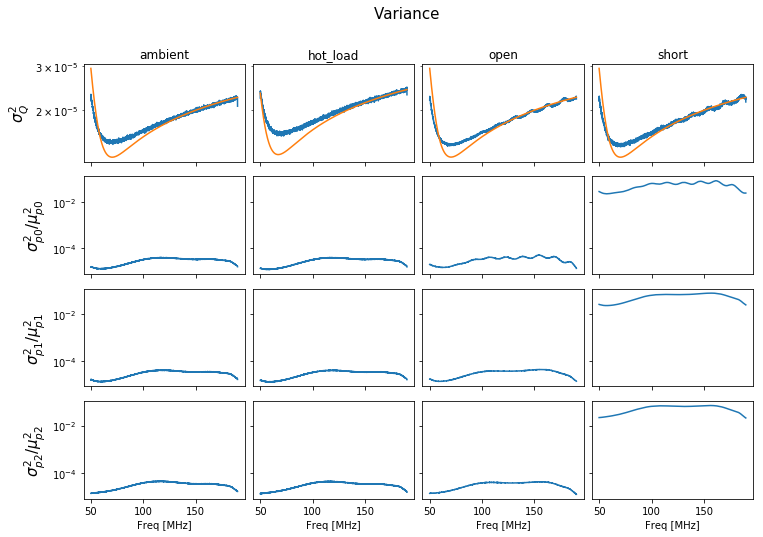

In [98]:
fig, ax = plt.subplots(4,4, figsize=(12, 8), sharex=True, sharey='row', 
                       gridspec_kw={"hspace":0.15, 'wspace':0.05}, subplot_kw={"yscale":'log'})

Tp_eff=1.5
nu_p=17
w_p=1.7

for i, load in enumerate(calobs._sources):
    for j, k in enumerate(kind):
        ax[j,i].plot(calobs.freq.freq, filtered_var[load][k])

        if j==0:
            ax[j,i].set_title(load)
        
        if k=='temp':
            mysig = model_variance_with_p(calobs, load, Tr=Tr, int_time=int_time, b=b, Tp_eff=Tp_eff, nu_p=nu_p, w_p=w_p)
            
            if load == 'hot_load':
                multiplier = 5.15
            else:
                multiplier = 7.5
                
            ax.flatten()[i].plot(
                calobs.freq.freq,
                multiplier*mysig,
                label="My Model Variance"
            )

        if i==0:
            if k=='temp':
                ax[j,i].set_ylabel("$\sigma^2_Q$", fontsize=15)
            else:
                ax[j,i].set_ylabel(r"$\sigma^2_{%s}/\mu_{%s}^2$"%(k,k),fontsize=15)
                
        
for i in range(4):
    ax[3,i].set_xlabel("Freq [MHz]")

    
fig.suptitle("Variance", fontsize=15);



Clearly the parameters for the out-of-band noise have not been chosen appropriately here. We would hope that an actual fit would be able to fix this for us. Perhaps the form of the extra noise will have to be fiddled with.

 ## Empirical Noise Runs for Nature Paper

In this section we use a likelihood in which the variance on the model is _measured_ rather than modeled. 
The actual likelihood is created by the script `BayesianFits/create_config.py`, which takes some inputs for the number of terms and lowest frequency and produces a YAML file. We read the YAML in here as the full likelihood.

In [ ]:
from edges_estimate.calibration import CalibratorQ
from edges_estimate.likelihoods import CalibrationChi2
from getdist import plots, MCSamples
from yabf import samplers
from lmfit import Minimizer, Parameters
from yabf import load_likelihood_from_yaml

In [7]:
lk = load_likelihood_from_yaml("BayesianFits/Receiver01_25C_2015_09_02_040_to_200MHz_l52.0MHz_h98.0MHz_c7_w7_no_bounds/config.yml")

### Downhill-Gradient Fits

Instead of using the `samplers.run_map` function, which uses `scipy.optimize.minimize` directly, we use `lmfit`, which seems to do a better job at succeeding by default. 

In [10]:
params = Parameters()
for name, param in lk.child_active_param_dct.items():
    params.add(name, value=param.fiducial, min=param.min, max=param.max)

In [11]:
def vector_objective(params):
    model = lk.reduce_model(params=params)
    mask = model['data_mask']
    model = model['Qp']
    out = []
    for name, mod in model.items():
        out.append((mod - lk.data[name][mask])/(np.sqrt(2) * lk.sigma[name][mask]))
        
    out = np.concatenate(out)
        
    return out

In [12]:
vector_minm = Minimizer(vector_objective, params, nan_policy='omit')

In [13]:
vector_res = vector_minm.minimize(method='leastsq')

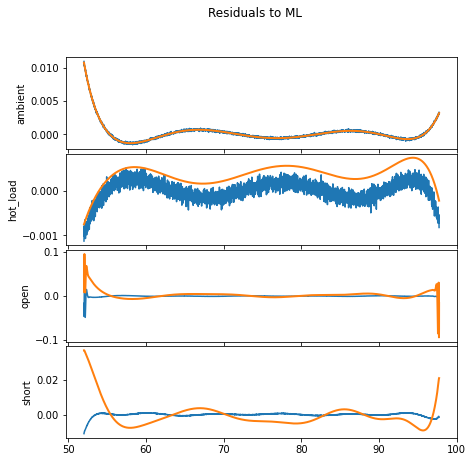

In [14]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(7,7), gridspec_kw={"hspace":0.05})

fid_model = lk.reduce_model()
data_mask = fid_model['data_mask']
fid_model = fid_model['Qp']

ml_model = lk.reduce_model(params=[p.value for p in vector_res.params.values()])['Qp']

fig.suptitle("Residuals to ML")
for i, (name, fid) in enumerate(fid_model.items()):
    ax[i].plot(lk['calibrator'].freq, lk.data[name][data_mask] - ml_model[name])
    ax[i].plot(lk['calibrator'].freq, fid - ml_model[name], lw=2)
    ax[i].set_ylabel(name)

In [20]:
for name in ml_model:
    
    print(name, 
          np.sqrt(np.mean(np.square(lk.data[name][data_mask] - ml_model[name]))),
          np.sqrt(np.mean(np.square(lk.data[name][data_mask] - fid_model[name])))
         )

ambient 0.00148224730901627 8.467023497528965e-05
hot_load 0.00021533380563226146 0.0003769610072088115
open 0.0029255239763110066 0.010103690424523477
short 0.0010859610875586807 0.00769606560317265


Yay! It worked _and_ got us error estimates!

In [21]:
def get_models_from_fit(fit, like, fid=False):
    if fid:
        params = [param.fiducial for param in like.child_active_params]
    else:
        params = list(fit.params.values())
        
    def _get(start):
        return np.poly1d([val for key, val in zip(like.child_active_param_dct.keys(), params) if key.startswith(start)][::-1])
    
    return _get('C1'), _get('C2'), _get('Tunc'), _get('Tcos'), _get('Tsin')        

In [22]:
c1, c2, tunc, tcos, tsin = get_models_from_fit(vector_res, lk, fid=False)
c1_fid, c2_fid, tunc_fid, tcos_fid, tsin_fid = get_models_from_fit(vector_res, lk, fid=True)


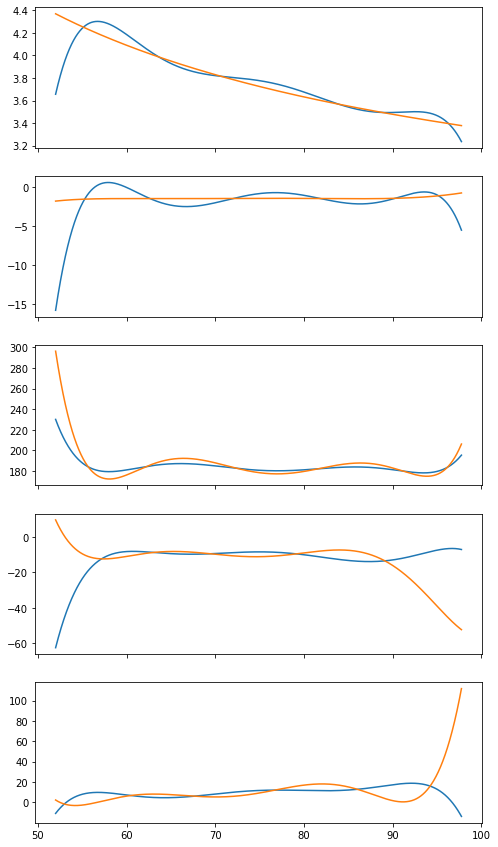

In [23]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8,15))

ax[0].plot(lk['calibrator'].freq, c1(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))
ax[0].plot(lk['calibrator'].freq, c1_fid(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))

ax[1].plot(lk['calibrator'].freq, c2(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))
ax[1].plot(lk['calibrator'].freq, c2_fid(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))

ax[2].plot(lk['calibrator'].freq, tunc(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))
ax[2].plot(lk['calibrator'].freq, tunc_fid(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))

ax[3].plot(lk['calibrator'].freq, tcos(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))
ax[3].plot(lk['calibrator'].freq, tcos_fid(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))

ax[4].plot(lk['calibrator'].freq, tsin(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))
ax[4].plot(lk['calibrator'].freq, tsin_fid(lk['calibrator'].calobs.freq.normalize(lk['calibrator'].freq)))


In [24]:
means = np.array([p.value for p in vector_res.params.values()])

In [25]:
np.savez('calibration_covariance.npz', covar=vector_res.covar, mean=means)

### Produce Data Covariance from Calibration Covariance

Now, the plan is to use the covariance estimate of the calibration parameters to obtain a set of re-calibrated Nature-paper data with covariances.

In [26]:
from scipy import stats
from pathlib import Path
from edges_analysis.analysis import s11 as s11m
from edges_cal import receiver_calibration_func as rcf

Now we need to define some functions to "decalibrate" the antenna temperature, and recalibrate it.

In [27]:
def get_cal_curves(params, like):
    def _get(start):
        return np.poly1d([val for key, val in zip(like.child_active_param_dct.keys(), params) if key.startswith(start)][::-1])
    
    return _get('C1'), _get('C2'), _get('Tunc'), _get('Tcos'), _get('Tsin')

def get_fid(params, like):
    return {name: val for name, val in zip(['c1', 'c2', 'tunc', 'tcos', 'tsin'], get_cal_curves(params, like))}

def get_K(freq, like):
    lna = like['calibrator'].calobs.lna.s11_model(freq)
    
    s11_files = sorted(Path('/data5/edges/data/S11_antenna/low_band/20160830_a/s11').glob('*.s1p'))

    switch_state_dir = '/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/S11/SwitchingState01'
    switch_state_run_num = 1
    n_terms = 13

    model, raw_s11, raw_freq = s11m.antenna_s11_remove_delay(
        s11_files,
        freq,
        switch_state_dir=switch_state_dir,
        delay_0=0.17,
        n_fit=n_terms,
        switch_state_run_num=switch_state_run_num,
    )

    return rcf.get_K(lna, model(freq))
    

def recalibrate(freq, temp, params, fid, K, like):
    scale, offset, tu, tc, ts = get_cal_curves(params, like)

    a, b = rcf.get_linear_coefficients_from_K(
        K, scale(freq), offset(freq), tu(freq), tc(freq), ts(freq), t_load=300,
    )

    decal = (temp - b)/a

    a, b = rcf.get_linear_coefficients_from_K(
        K, fid['c1'](freq), fid['c2'](freq), fid['tunc'](freq), fid['tcos'](freq), fid['tsin'](freq), t_load=300,
    )
    
    return decal*a + b

In [28]:
ntrials = 5000

nature_paper_data = np.genfromtxt('nature-paper-data.csv', skip_header=1, delimiter=',')

nat_freq = nature_paper_data[:, 0]
nat_temp = nature_paper_data[:, 2]

nat_freq = nat_freq[nat_temp>0]
nat_temp = nat_temp[nat_temp>0]
nat_freq_renorm = lk['calibrator'].calobs.freq.normalize(nat_freq)

covar = np.load('calibration_covariance.npz')['covar']
means = np.load('calibration_covariance.npz')['mean']

fid = get_fid(means, lk)
K = get_K(nat_freq, lk)

dst = stats.multivariate_normal(mean=means, cov=covar, allow_singular=True)

new_temps = np.zeros((ntrials, len(nat_temp)))
pp = []
c1 = np.zeros_like(new_temps)
c2 = np.zeros_like(new_temps)
tunc = np.zeros_like(new_temps)
tcos = np.zeros_like(new_temps)
tsin = np.zeros_like(new_temps)

for i in range(ntrials):
    params = dst.rvs()
    _c1, _c2, _tunc, _tcos, _tsin = get_cal_curves(params, lk)
    c1[i] = _c1(nat_freq_renorm)
    c2[i] = _c2(nat_freq_renorm)
    tunc[i] = _tunc(nat_freq_renorm)
    tcos[i] = _tcos(nat_freq_renorm)
    tsin[i] = _tsin(nat_freq_renorm)
    
    new_temps[i] = recalibrate(nat_freq_renorm, nat_temp, params, fid, K,lk)
    pp.append(params)

Text(0, 0.5, 'Recal - Fiducial (K)')

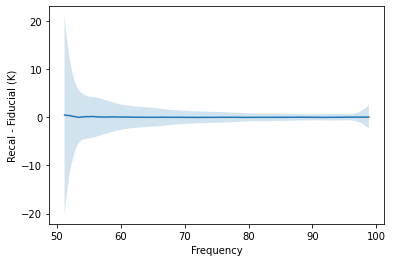

In [29]:
perc = np.percentile(new_temps, [16, 50, 84], axis=0)
plt.fill_between(nat_freq, perc[0] - nat_temp, perc[2]-nat_temp, alpha=0.2, label='Error Region')
plt.plot(nat_freq, perc[1]-nat_temp, label='Median')
#plt.plot(nat_freq, nat_temp, label='Fiducial')
plt.xlabel("Frequency")
plt.ylabel("Recal - Fiducial (K)")


In [30]:
data_cov = np.cov(new_temps.T)
data_corr = np.corrcoef(new_temps.T)

In [31]:
np.savez('data_covariance.npz', cov=data_cov, mean=np.mean(new_temps, axis=0))

Text(0, 0.5, 'Frequency [MHz]')

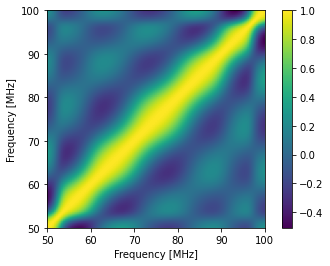

In [32]:
plt.imshow(data_corr.T, origin='lower', extent=(50, 100, 50, 100))
plt.colorbar()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Frequency [MHz]")

### Fit Nature Paper Model

In [ ]:
nature_paper_data = np.genfromtxt('nature-paper-data.csv', skip_header=1, delimiter=',')

nat_freq = nature_paper_data[:, 0]
nat_temp = nature_paper_data[:, 2]
nat_wght = nature_paper_data[:, 1]

nat_freq = nat_freq[nat_temp>0]
nat_temp = nat_temp[nat_temp>0]
nat_wght = nat_wght[nat_wght>0]

cov = np.load('data_covariance.npz')['cov']
mean = np.load('data_covariance.npz')['mean']

# Add thermal noise to the covariance
cov += np.diag(0.025 * np.ones(len(cov)))

In [10]:
def make_fg(n):
    params = {
        'beta': {'min': -3.5, 'max': -2.5, 'prior': stats.norm(loc=-2.55, scale=0.01)},
        'p0': {'min': 1500, 'max': 2000},
    }
    for i in range(1,n):
        params[f'p{i}'] = {'min': -10000, 'max': 10000}
        
    return LinLog(
        name='fg',
        freqs=nat_freq,
        poly_order=n,
        params=params,
        use_p1=True
    )

In [11]:
def make_absorption(fix=tuple()):
    params={
        'A': {'max':2, 'min': 0, 'fiducial': 0.5}, 
        'nu0': {'min': 60, 'max': 90, 'fiducial': 78}, 
        'tau': {'min': 1, 'max': 20, 'fiducial': 8}, 
        'w': {'min':1, 'max': 25, 'fiducial': 15}
    }
    
    fid = {}
    for p in fix:
        fid[p] = params.pop(p)['fiducial']
        
    return AbsorptionProfile(
        name='absorption',
        fiducial=fid,
        params=params,
        freqs=nat_freq
    )


In [12]:
final_lk = MultiComponentChi2(
    components=(
        make_absorption(),
        make_fg(5)
    ),
    kind='spectrum',
    data=nat_temp,
    sigma=cov
)

In [82]:
final_lk_var = attr.evolve(final_lk, sigma=np.diag(np.sqrt(cov)))
final_lk_therm = attr.evolve(final_lk, sigma=0.025)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [83]:
res_var = run_map(final_lk_var)

In [84]:
res_therm = run_map(final_lk_therm)

In [85]:
res_therm.success, res_therm.x

(True,
 array([ 7.37109693e-01, -2.56670037e+00,  1.75082452e+03,  0.00000000e+00,
        -6.67314123e+01, -2.01850021e+01,  4.26682022e+00,  8.21486125e-01,
        -3.62572696e+00,  8.14205734e-01]))

In [86]:
def plot_residual(p, lk):
    ctx = lk.get_ctx(params=p)
    model = lk.reduce_model(params=p)
    fig, ax = plt.subplots(2,1, sharex=True)
    ax[0].plot(nat_freq, nat_temp - model)
    ax[1].plot(nat_freq, ctx['eor_spectrum'])

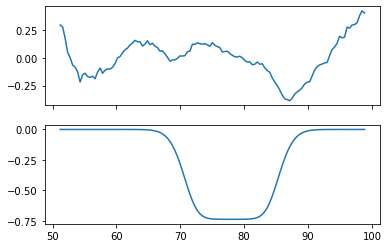

In [87]:
plot_residual(res_therm.x, final_lk_therm)

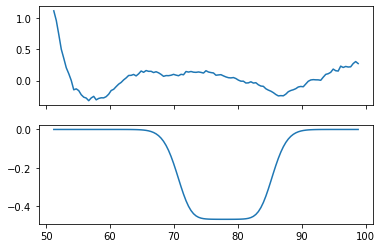

In [88]:
plot_residual(res_var.x, final_lk_var)

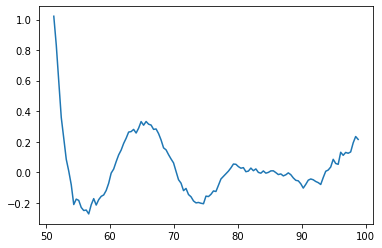

In [41]:
plt.plot(nat_freq, mean - model)

Can also try fitting directly with a linear model:

In [13]:
physlin = mdl.PhysicalLin(default_x=nat_freq, n_terms=5)
physlin_fit = physlin.fit(ydata=nat_temp)

In [14]:
edgespoly = mdl.EdgesPoly(default_x=nat_freq, n_terms=5)
edgespoly_fit = edgespoly.fit(ydata=nat_temp)

In [15]:
linlog = mdl.LinLog(default_x=nat_freq, n_terms=5)
linlog_fit = linlog.fit(ydata=nat_temp)

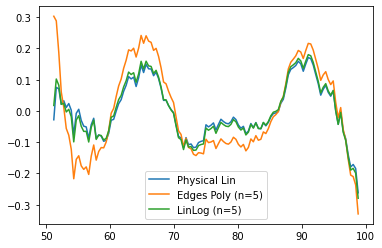

In [16]:
plt.plot(physlin_fit.xdata, physlin_fit.residual, label='Physical Lin')
plt.plot(edgespoly_fit.xdata, edgespoly_fit.residual, label='Edges Poly (n=5)')
plt.plot(linlog_fit.xdata, linlog_fit.residual, label='LinLog (n=5)')
plt.legend()

We can define a faster fitting function for the absorption parameters:

In [48]:
def get_eor(p, absorption):
    return absorption(params=p)['eor_spectrum']
    
def get_resid(p, absorption, data, fg, sigma):
    eor = get_eor(p, absorption)
    resid = data - eor
    return fg.fit(ydata=resid, weights=1/sigma**2 if hasattr(sigma, '__len__') else None).residual
    
def neg_lk(p, absorption, data, fg, sigma):
    resid = get_resid(p, absorption, data, fg, sigma)
    if hasattr(sigma, 'ndim') and sigma.ndim==2:
        norm_obj = stats.multivariate_normal(mean=np.zeros_like(resid), cov=sigma)
    else:
        norm_obj = stats.norm(loc=0, scale=sigma)
        
    return -np.sum(norm_obj.logpdf(resid))
#    return np.sum(resid**2/(2*sigma**2))

[autoreload of yabf.chi2 failed: Traceback (most recent call last):
  File "/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/attr/_make.py", line 419, in _frozen_setatt

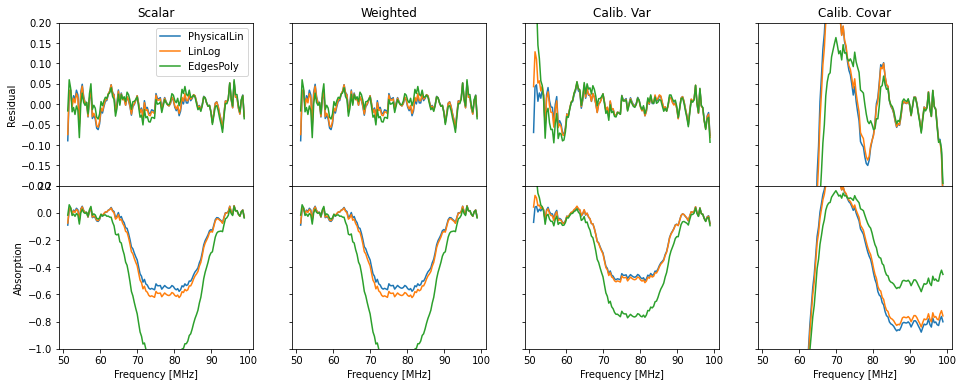

In [58]:
eor =  make_absorption()

res_dict = {}

fig, ax = plt.subplots(2,4, sharex=True, figsize=(16,6), sharey='row', gridspec_kw={'hspace':0})
for j, (name, sigma) in enumerate(zip(
    ['Scalar', 'Weighted', 'Calib. Var', 'Calib. Covar'],
    [0.025, 0.025/(nat_wght/nat_wght.max()), np.sqrt(np.diag(cov)), cov])):
    res_dict[name] = {}
    for i, fg in enumerate([physlin, linlog, edgespoly]):
        res = minimize(
            neg_lk, 
            x0=[apar.fiducial for apar in eor.child_active_params], 
            args=(eor, nat_temp, fg, sigma),
            bounds=[(apar.min, apar.max) for apar in eor.child_active_params],
        )
        
        resid = get_resid(res.x, eor, nat_temp, fg, sigma)
        # resid_nature = get_resid([0.53, 78.1, 7, 18.7], eor, nat_temp, fg, sigma)
        absorp = get_eor(res.x, eor)
        
        ax[0, j].plot(nat_freq, resid, label=fg.__class__.__name__, color=f'C{i}')
        ax[1, j].plot(nat_freq, absorp + resid, label=fg.__class__.__name__, color=f'C{i}')
        ax[0,j].set_ylim(-0.2,0.2)
        ax[1, j].set_ylim(-1, 0.2)
        
        res_dict[name][fg.__class__.__name__] = res
        #ax.flatten()[j].plot(nat_freq, resid_nature,ls='-', label=fg.__class__.__name__, color=f"C{i}")
    ax[0, j].set_title(name)
    ax[1, j].set_xlabel("Frequency [MHz]")
    
ax[0,0].set_ylabel("Residual")
ax[1,0].set_ylabel("Absorption")
ax[0,0].legend()

In [53]:
reslinlog = res_dict['Calib. Covar']['LinLog']
resid = get_resid(reslinlog.x, eor, nat_temp, linlog, cov)
absorp = get_eor(reslinlog.x, eor)
eor_resid = nat_temp - absorp
fg_params = linlog.fit(ydata=eor_resid, weights=1/cov**2)
fg_spectrum = fg_params.evaluate()

In [54]:
lk_params = reslinlog.x.tolist() + [-2.5] + fg_params.model_parameters.tolist()

In [55]:
ctx = final_lk.get_ctx(params=lk_params)

In [56]:
model = final_lk.reduce_model(params=lk_params)
final_lk.lnl(model)
#plt.plot(fg_spectrum)

84.15220014770935

In [57]:
neg_lk(reslinlog.x, eor, nat_temp, linlog, cov)

-84.15220014771185

In [60]:
np.save('nature-paper-freqs.npy', nat_freq)
np.save('nature-paper-temperature.npy', nat_temp)
np.save('data-variance.npy', np.diag(cov))

In [6]:
from getdist import MCSamples, loadMCSamples

In [7]:
samples = loadMCSamples('PolyChordChains/parameter_estimation_linlog')

In [8]:
from getdist.plots import get_single_plotter

<Figure size 432x324 with 0 Axes>

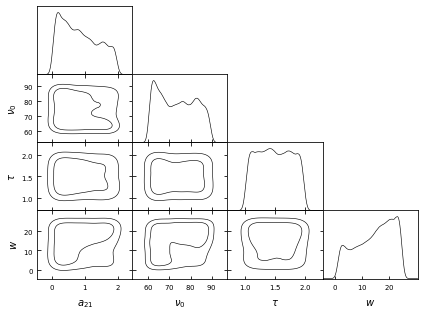

In [13]:
g = get_single_plotter()
g.triangle_plot(samples, ['A', 'nu0', 'tau', 'w'])

((-0.44636470452317234, 2.441958983675424),
 (52.48408136846825, 97.49529067143574))

In [70]:
MCSamples.loadChains?

### emcee

The idea here is to run emcee and identify whether the posteriors align with the generated covariance from the previous section.

#### Cal Fit

In [26]:
sampler = samplers.emcee(
    lk, 
    sampler_kwargs={
        "nwalkers": 300, 
        'threads': 24
    }, 
    output_dir="emcee"
)

In [37]:
i_lower = np.tril_indices(len(vector_res.covar), -1)
cov = np.zeros((vector_res.nvarys, vector_res.nvarys))
cov.T[i_lower] = vector_res.covar[i_lower]
cov[i_lower] = vector_res.covar[i_lower]

In [38]:
refs = np.random.multivariate_normal(
    np.array([p.value for p in vector_res.params.values()]), 
    cov, size=(300, )
)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
samples = sampler.sample(
    nsteps=1000, 
    refs=refs
)

Removed no burn in


In [11]:
samples.getMeans()

NameError: name 'samples' is not defined

In [223]:
import corner

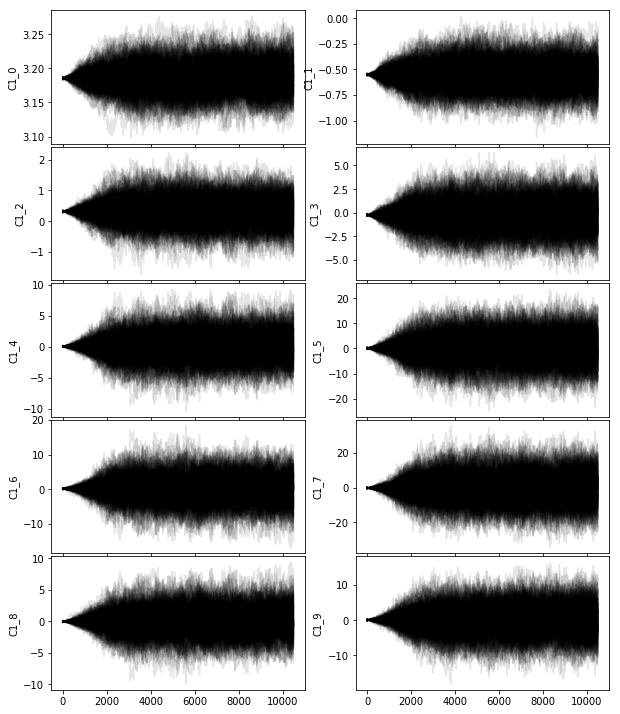

In [282]:
n = 10
fig, ax = plt.subplots(n//2, 2, sharex=True, figsize=(10,n*1.25), gridspec_kw={"hspace":0.02})

for i, name in enumerate(lk.child_active_param_dct):
    if i==10:
        break
        
    ax.flatten()[i].set_ylabel(name)
    for walker in sampler._sampler.chain:
        ax.flatten()[i].plot(walker[:, i], color='k', alpha=0.1)

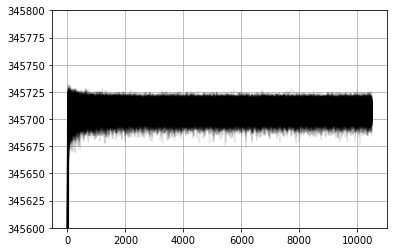

In [283]:
for walker in sampler._sampler.lnprobability:
    plt.plot(walker, color='k', alpha=0.1)
plt.ylim(345600, 345800)
plt.grid(True)

In [285]:
(np.array([p.value for p in vector_res.params.values()]) - sampler._sampler.chain[264, 57])/np.sqrt(np.diag(vector_res.covar))

array([ 3.30030957e-01, -2.03505196e-02,  2.53089308e-01,  1.33191263e-01,
       -6.80680272e-04, -1.42884307e-01, -6.76555050e-01,  4.30494849e-01,
        1.44576966e-01, -8.29716415e-01, -1.17756537e-01, -9.47206316e-01,
       -1.79437277e-01,  7.29772226e-01, -1.12920779e-01, -2.12206818e-01,
       -3.25638496e-01,  1.37412731e-01,  2.11835147e-01, -4.07794693e-01,
       -6.02680466e-01,  3.58977391e-01, -3.19598459e-01, -4.95866562e-01,
        3.05889652e-01, -9.92153536e-02,  3.75763556e-01,  3.87445725e-02,
       -1.12264229e-01,  1.93362751e-01, -6.28651356e-02, -3.01086653e-01,
       -2.57274221e-01, -1.55387046e-01,  2.23646406e-01,  1.62991170e-01,
       -3.43556107e-01, -2.77825726e-03,  2.39617621e-01,  8.56976086e-02,
       -1.52767641e-01, -1.31343689e-01,  2.47207212e-01, -2.69423408e-02,
        4.87404579e-01,  6.28168848e-01, -1.04495625e+00, -1.56679293e-01,
       -1.49415936e-01,  5.25349253e-01, -1.08625488e-01, -3.29446059e-02,
        3.37654030e-01, -

In [284]:
np.where(sampler._sampler.lnprobability == sampler._sampler.lnprobability.max())

(array([264]), array([57]))

In [298]:
sampler._sampler.get_chain?

In [301]:
samples = MCSamples(
    samples=sampler._sampler.get_chain(flat=False, discard=4000),
    names=[a.name for a in lk.child_active_params],
    labels=[p.latex for p in lk.child_active_params],
)

Removed no burn in


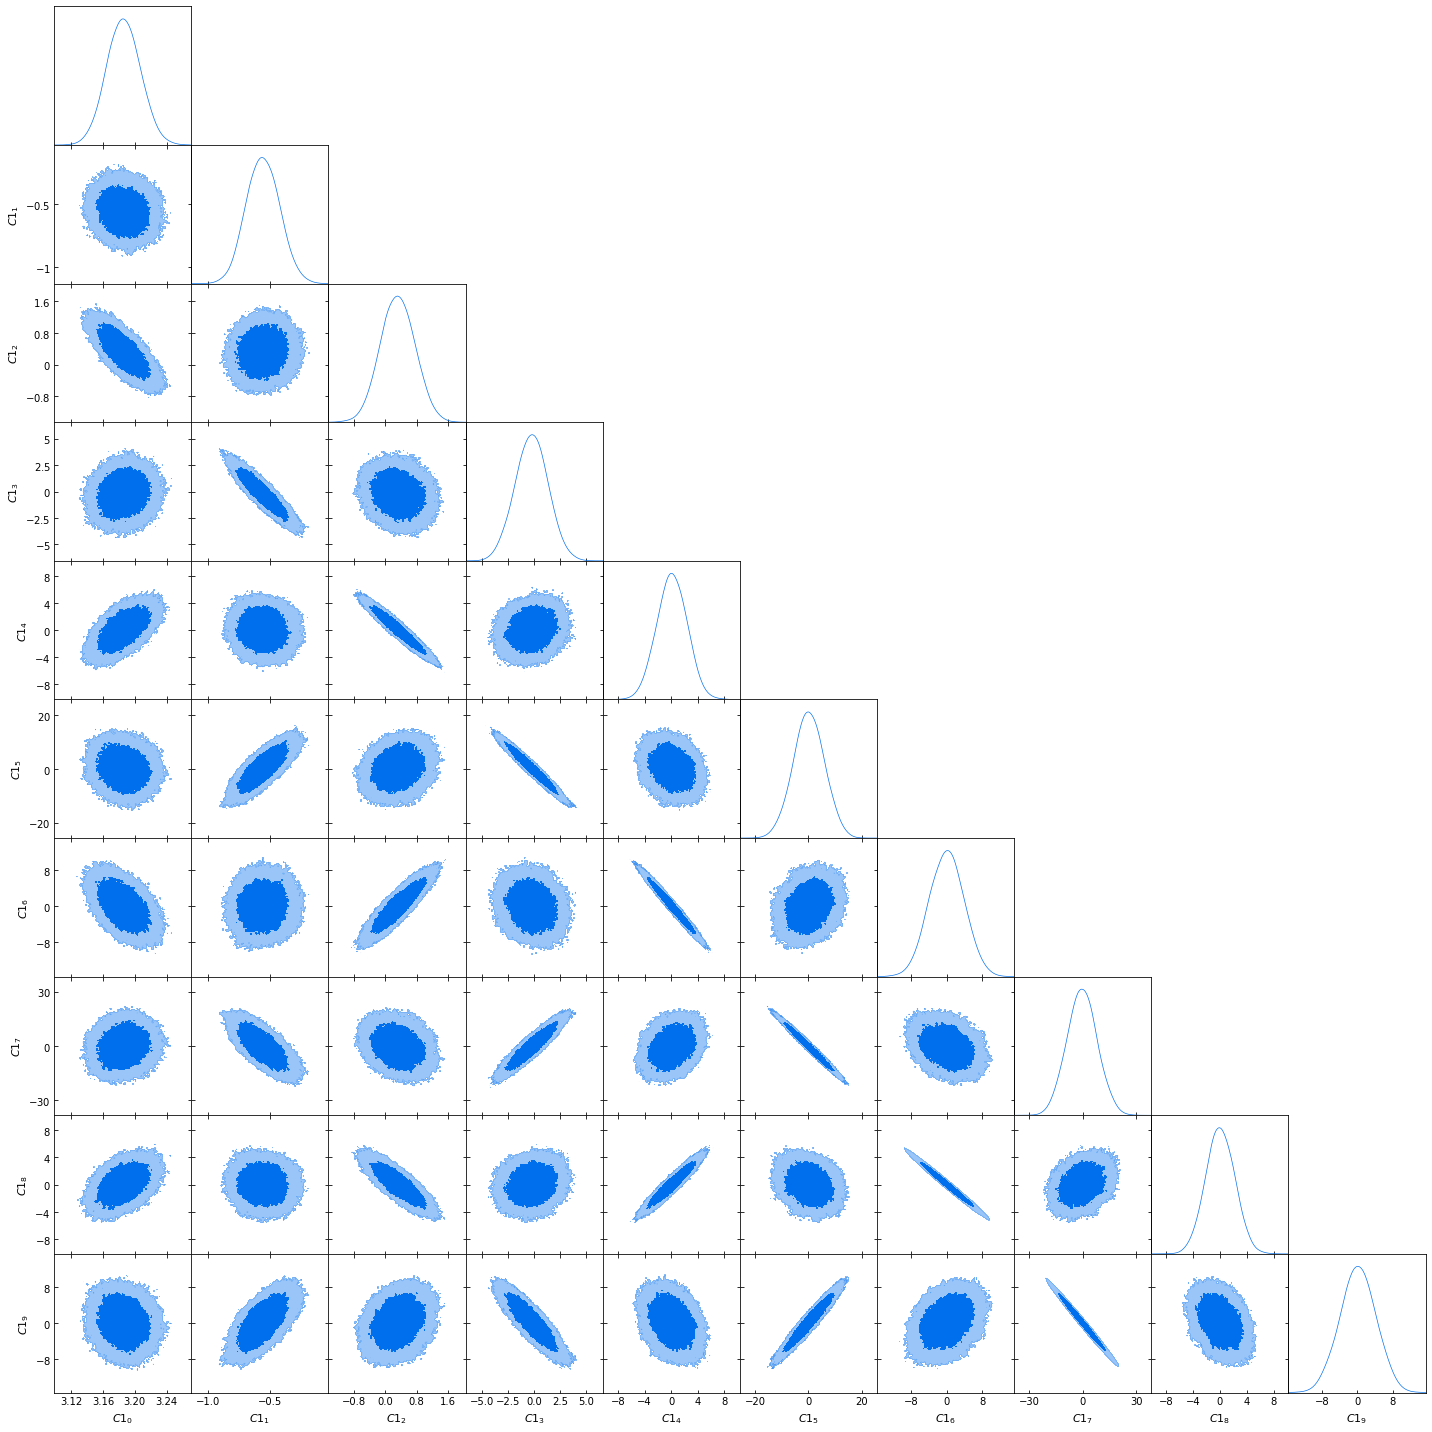

In [311]:
g = plots.getSubplotPlotter()
g.triangle_plot(samples, params=[f'C1_{i}' for i in range(10)], filled=True)

In [317]:
n = 2000
small_sample = samples.samples[np.random.choice(samples.samples.shape[0], size=n)]

In [337]:
keys = [r"$C_1$", r"$C_2$", r"$T_{\rm unc}$", r"$T_{\rm cos}$", r"$T_{\rm sin}$"]
models = {key: np.zeros((n, len(lk['calibrator'].freq))) for key in keys}

for j, parameter_set in enumerate(small_sample):
    parameter_dict = lk._fill_params(params=parameter_set)
    
    for i, (name, poly) in enumerate(zip(keys, lk['calibrator'].get_calibration_curves(parameter_dict['calibrator']))):
        models[name][j] = poly            

In [338]:
quantiles = {name: np.quantile(poly, [0.04, 0.16, 0.5, 0.84, 0.96], axis=0) for name, poly in models.items()}

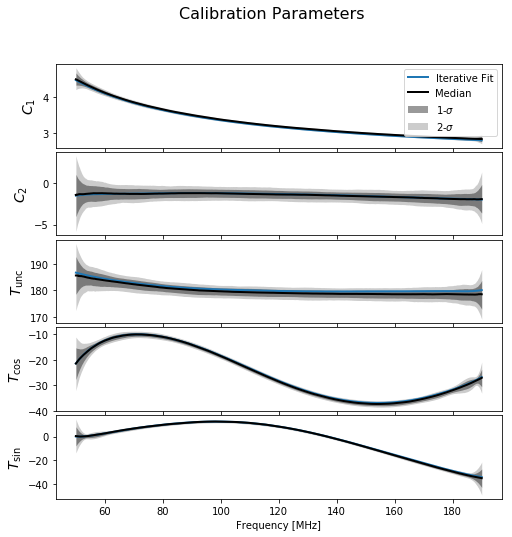

In [344]:
plot_quantiles = True

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8), gridspec_kw={"hspace":0.05})

fid = lk['calibrator'].get_calibration_curves(lk.fiducial_params['calibrator'])
    
fig.suptitle("Calibration Parameters", fontsize=16)
for i, (name, quantile) in enumerate(quantiles.items()):
    ax[i].set_ylabel(name, fontsize=14)
    ax[i].plot(lk['calibrator'].freq, fid[i], color='C0', lw=2, label="Iterative Fit")

    if plot_quantiles:
        ax[i].plot(lk['calibrator'].freq, quantile[2], color='k', lw=2, label="Median")
        ax[i].fill_between(lk['calibrator'].freq, quantile[1], quantile[-2], color='k', alpha=0.4, lw=0, label=r"1-$\sigma$")
        ax[i].fill_between(lk['calibrator'].freq, quantile[0], quantile[-1], color='k', alpha=0.2, lw=0, label=r"2-$\sigma$")
    
            
ax[0].legend()
ax[-1].set_xlabel("Frequency [MHz]")
plt.tight_layout();

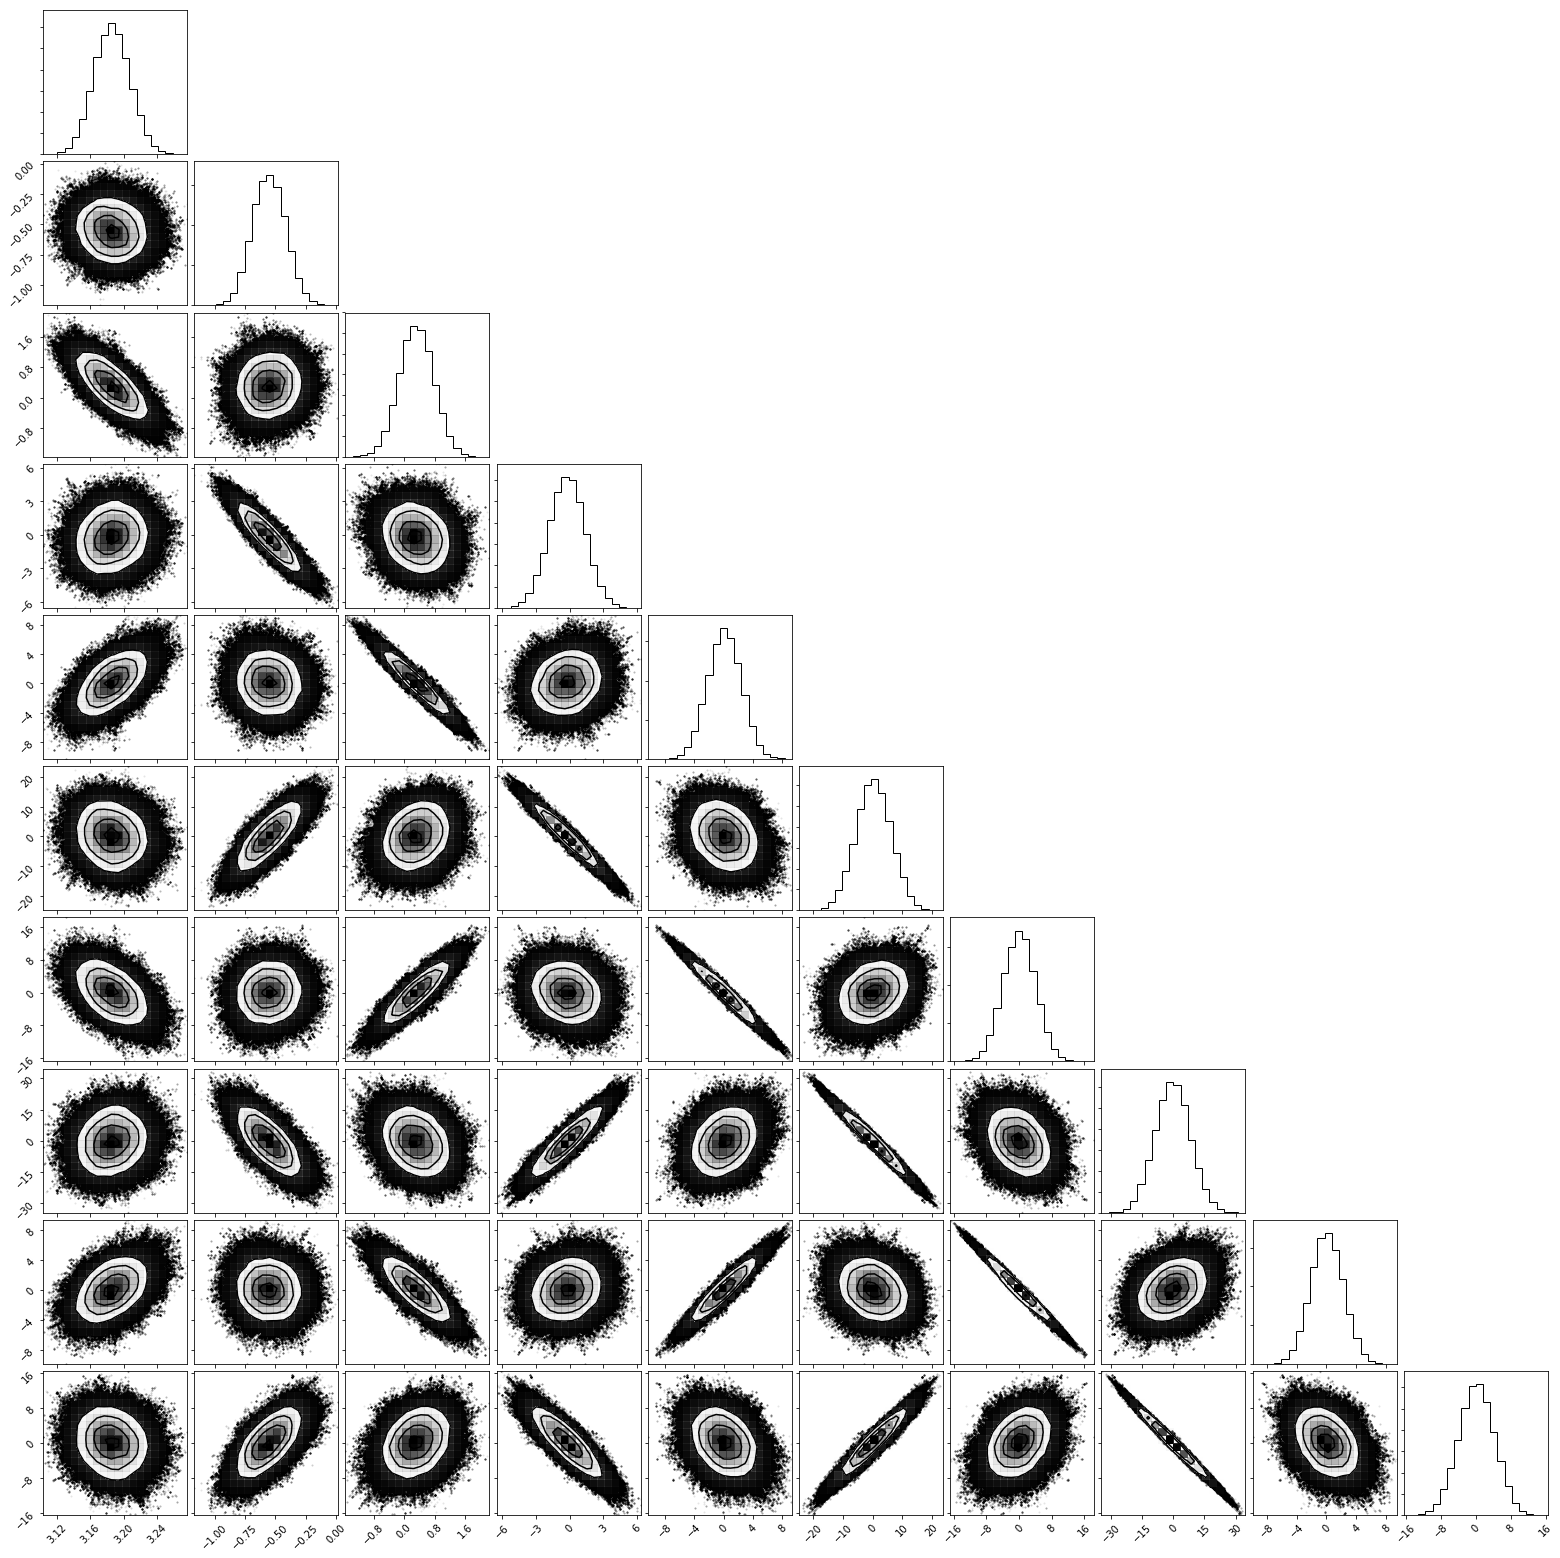

In [292]:
corner.corner(sampler._sampler.chain[:, 4000:, :10].reshape((-1, 10)));

#### Final Fit

In [11]:
final_sampler = samplers.emcee(
    final_lk, output_dir='emcee', output_prefix='final', 
    sampler_kwargs={
        "nwalkers": 300, 
        'threads': 24
    }, 
)

In [ ]:
final_samples = final_sampler.sample(nsteps=1000)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [19]:
final_samples.getMeans()

array([ 6.96042118e-01,  7.53092421e+01,  1.22792501e+01,  1.68575238e+01,
       -2.55377550e+00,  1.74988531e+03, -2.72953291e+02, -5.70028934e+01,
       -3.36116410e+02, -7.34062378e+02])

In [20]:
model = final_lk.reduce_model(params=final_samples.getMeans())

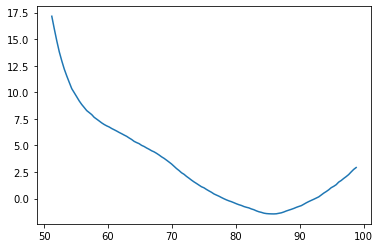

In [21]:
plt.plot(nat_freq, mean - model)

### Plots from polychord run

In this section we make plots and do analysis on a run done in `BayesianFits/` using polychord (not done in the notebook because I wanted full parallelisation).

In [ ]:
from getdist import loadMCSamples, plots
from yabf import load_likelihood_from_yaml

In [12]:
samples = loadMCSamples("BayesianFits/config")

BayesianFits/config.txt


Removed no burn in


In [13]:
samples

In [17]:
g = plots.getSubplotPlotter()

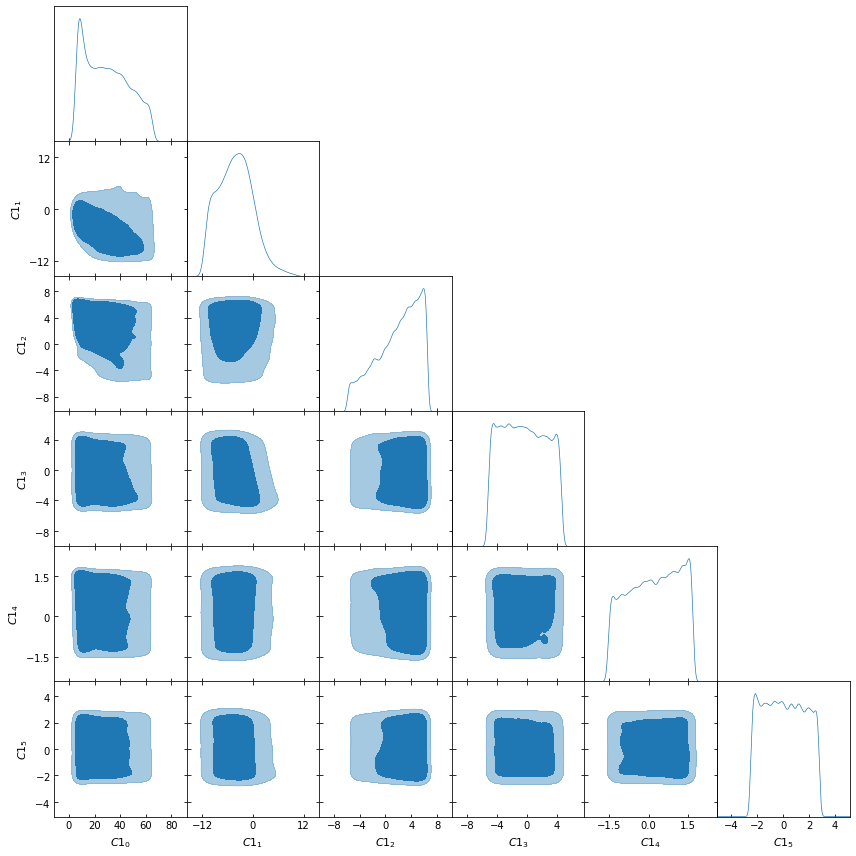

In [18]:
g.triangle_plot(samples, params=['C1_0', 'C1_1', 'C1_2', 'C1_3', 'C1_4', 'C1_5'], filled=True,
               contour_colors=[f'C{i}' for i in range(7)])

Checking root folder: /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C
Checking S11 folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/S11
Checking Spectra folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Spectra
Checking Resistances folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Resistance
Checking Spectra folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Spectra
Checking Resistances folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Resistance
Checking S11 folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/S11


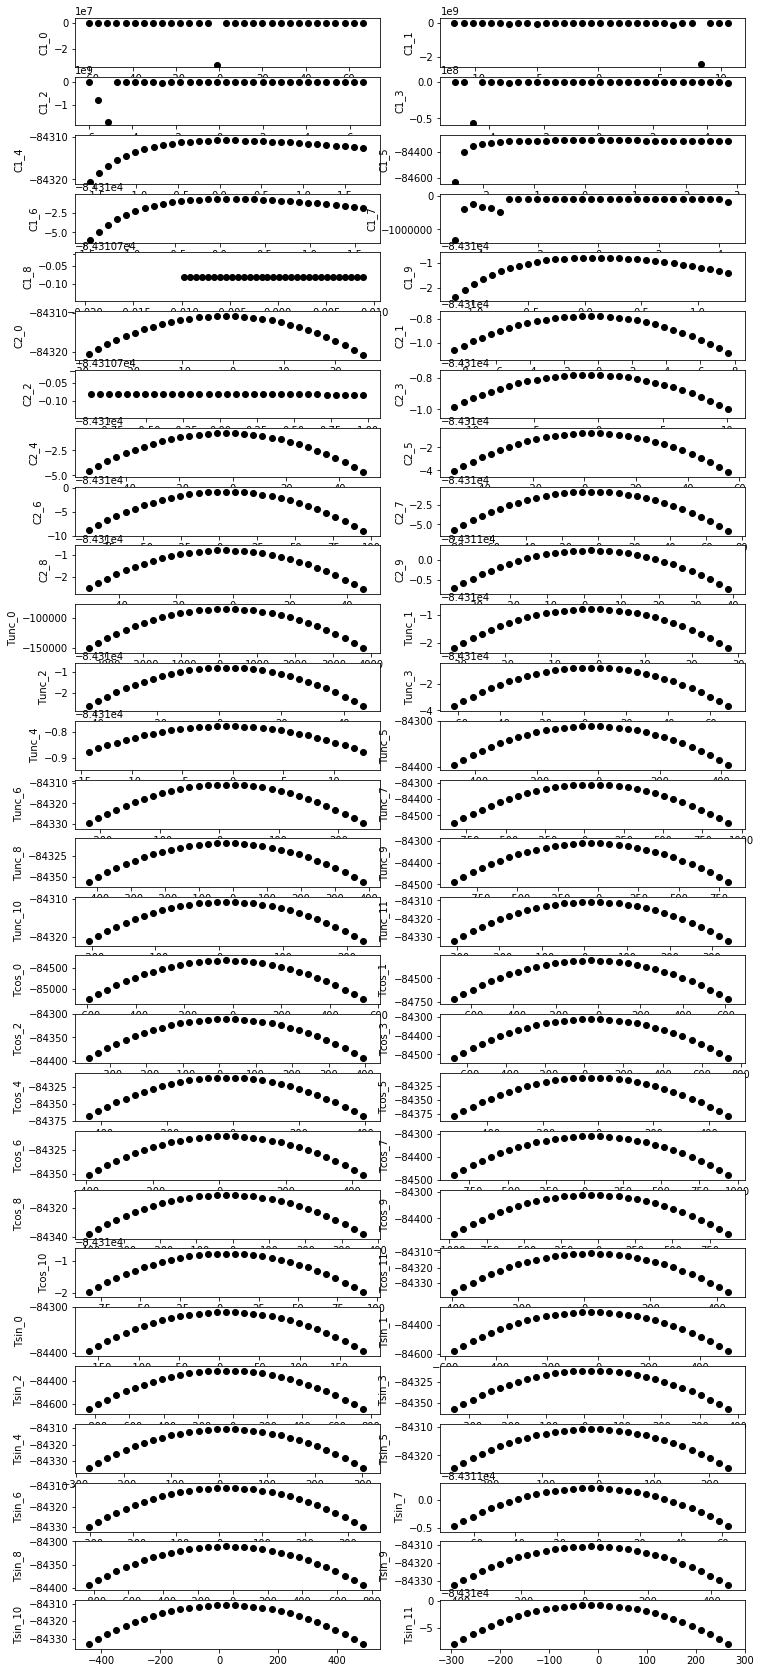

In [36]:
fig, ax = plt.subplots(len(lk.child_active_param_dct)//2, 2, figsize=(12,30))

for i, (name, param) in enumerate(lk.child_active_param_dct.items()):
    fid = lk.fiducial_params['calibrator'][name]
    
    xx = np.linspace(fid - 20*np.abs(fid), fid+20*np.abs(fid), 31)
    
    ax.flatten()[i].set_ylabel(name)
    for x in xx:
        ll = lk.logp(params={name: x})
        ax.flatten()[i].scatter(x, ll, color='k')

In [7]:
lk.logp(), lk.logp(params={"C1_0":1})

/data4/smurray/Projects/radio/EOR/Edges/cal_coefficients/src/edges_cal/modelling.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=9.87901e-18): result may not be accurate.
  param = sp.linalg.solve(R1, np.dot(Q1.T, Wydata))
/data4/smurray/Projects/radio/EOR/Edges/cal_coefficients/src/edges_cal/modelling.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=1.97509e-17): result may not be accurate.
  param = sp.linalg.solve(R1, np.dot(Q1.T, Wydata))


(-84310.77919882872, -84974.72152261111)

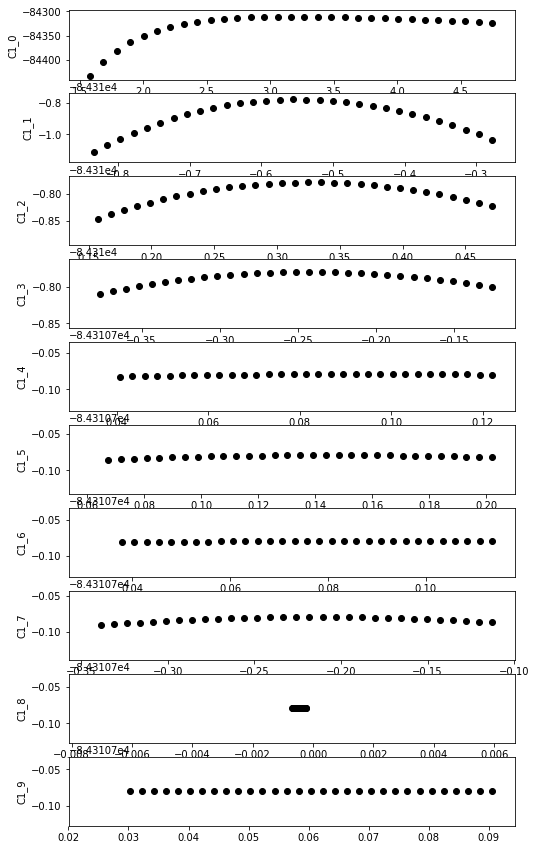

In [14]:
fig, ax = plt.subplots(10, 1, figsize=(8,15))

for i, (name, param) in enumerate(lk.child_active_param_dct.items()):
    if not name.startswith("C1"):
        continue
        
    fid = lk.fiducial_params['calibrator'][name]
    
    xx = np.linspace(fid - np.abs(fid)/2, fid+np.abs(fid)/2, 31)
    
    ax.flatten()[i].set_ylabel(name)
    for x in xx:
        ll = lk.logp(params={name: x})
        ax.flatten()[i].scatter(x, ll, color='k')